## Summary
This project performs clustering analysis using a few factors, then use the clustersfor "classification neutral" stock selction. We will compare this neutrality strategy to a more traditional sector neutral strategy.

### 1. Import package & variables setup

In [204]:
import pandas as pd
import numpy as np
from os import path
import os

# import KMeans
from sklearn.cluster import KMeans

# import hierarchical clustering libraries
import scipy.cluster.hierarchy as sch
from sklearn.cluster import AgglomerativeClustering

# set sql connection
import pyodbc
server = 'RIC1D2RSGSQL01' 
database = 'EquityResearch' 
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server};SERVER='+server+';DATABASE='+database+';Trusted_Connection=yes;')

# data viz packages
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as plty
from plotly.subplots import make_subplots

In [233]:
clr1 = ["#00ab4e","#58595b","#939598","#000000","#FFFFFF"]
# clr2 = ["#009697","#8dc63f","#f7941d","#ee2f53","#00b5f1","#96157c","#00ab4e","#58595b"]
clr2 = ["#00ab4e","#b1b3b6","#009697","#8dc63f",'#00b5f1','#f7941d','#96157c','#fabfb7','#ee2f53',
       '#b6e4fa','#0066b3','#ffd000','#58595b','#8dc0c4','#c84723','#c4df9b','#103c68','#8f7890',
        '#ffe694','#265b3f','#fbb161','#4b254c']

sc_path = os.path.expanduser("~\\OneDrive - IHS Markit\\ResearchSignals\\Projects\\20200213_StockClustering")
file1 = 'Factor_data_USLC_2019.txt'
file2 = 'Factor_data_USTC_2019.txt'
file3 = 'Factor_data_USLC_2010to2019.txt'


In [248]:
# create Timer class for future use
import time
class Timer(object):
    def __init__(self, name=None):
        self.name = name

    def __enter__(self):
        self.tstart = time.time()

    def __exit__(self, type, value, traceback):
        if self.name:
            print('[%s]' % self.name,)
        print('Elapsed: %s' % (time.time() - self.tstart))

### 2. Load data

In [157]:
sc_data = pd.read_csv(path.join(sc_path,file3), sep='\t')
sc_data.head()

,Date,FactorId,SecurityId,Rank,RawRatio
0,2010-01-29 00:00:00,5,00163T10,1827,NaN
1,2010-01-29 00:00:00,5,00766T10,3836,NaN
2,2010-01-29 00:00:00,5,04621X10,3633,NaN
3,2010-01-29 00:00:00,5,05348410,1817,NaN
4,2010-01-29 00:00:00,5,20605P10,1577,NaN


Factor & ID mapping

|Factor Group|Factor|Factor ID|Factor Name|
|------------|------|---------|-----------|
|Profitability|ROIC|249|Return on Invested Capital|
|Profitability|FCFROI|146|Free Cash Flow Return on Invested Capital|
|Profitability|GPM|7408|TTM Gross Profit Margin|
|Valuation|EBITDAP|106|TTM EV/EBITDA|
|Valuation|TTMSP|304|TTM Price to Sale|
|Valuation|BP|29|Book-to-Market|
|Momentum|ActRtn12M|5|12-Month Active Return with 1-month Lag|
|Momentum|ActRtn3M|11|3-Month Active Return with 1-month Lag|
|Momentum|FF10MRtn|148|Fama-French Momentum|
|Management Quality|ChgShare|73|Percent Change in Shares Outstanding|


In [12]:
# create dict for factor id to name mapping
fac_dict = {5:'ActRtn12M',
            11:'ActRtn3M',
            29:'BP',
            73:'ChgShare',
            106:'EBITDAP',
            146:'FCFROI',
            148:'FF10MRtn',
            249:'ROIC',
            304:'TTMSP',
            7408:'GPM'}

In [158]:
# test = sc_data.loc[(sc_data.Date == '2019-01-31 00:00:00') & (sc_data.FactorId == 29),]
# test.shape

sc_data.groupby(['Date','FactorId']).Rank.median()

Date                 FactorId
2010-01-29 00:00:00  5           2418.0
                     11          2648.5
                     29          2540.0
                     73          1978.5
                     106         1976.0
                                  ...  
2020-02-17 00:00:00  146         2569.5
                     148         5331.0
                     249         2636.0
                     304         5318.0
                     7408        3532.0
Name: Rank, Length: 1220, dtype: float64

In [159]:
# Creating crosssectional ranking columns

sc_data['cs_PRank'] = sc_data.groupby(['Date','FactorId']).Rank.rank(pct=True)

sc_data.sort_values(['Date','SecurityId']).head()
sc_data[(sc_data.SecurityId == 'AAPL') & (sc_data.Date == '2019-09-30 00:00:00')] # no Sep 2019???

# double check the percentile ranck, look good
# sc_data.loc[(sc_data.Date == '2019-01-31 00:00:00') & 
#             (sc_data.FactorId == 29) & 
#             (sc_data.prank < 0.05),].sort_values(['prank'])



,Date,FactorId,SecurityId,Rank,RawRatio,cs_PRank
1317415,2019-09-30 00:00:00,5,AAPL,7104,-8.11214,0.573889
1318636,2019-09-30 00:00:00,11,AAPL,14218,11.97280,0.913656
1319858,2019-09-30 00:00:00,29,AAPL,8328,0.09504,0.844797
1321079,2019-09-30 00:00:00,73,AAPL,262,-6.43300,0.088472
1322297,2019-09-30 00:00:00,106,AAPL,4535,0.07843,0.579230
1322440,2019-09-30 00:00:00,146,AAPL,393,0.22339,0.082740
1323504,2019-09-30 00:00:00,148,AAPL,8387,-7.51307,0.684448
1324724,2019-09-30 00:00:00,249,AAPL,348,0.29512,0.066487
1325791,2019-09-30 00:00:00,304,AAPL,6312,0.24841,0.671076
1327014,2019-09-30 00:00:00,7408,AAPL,4366,0.42575,0.642646


In [160]:
test = sc_data[sc_data.FactorId == 29].RawRatio
test.shape

(135291,)

### 3. Examine data

In [161]:
### pivot table the data to have factors as columns and PRank as values
a = sc_data.pivot_table(index=[pd.to_datetime(sc_data.Date),'SecurityId'], columns='FactorId', values='cs_PRank', fill_value = 0)

type(a)
a.rename(columns = fac_dict, inplace = True)
a.head()

FactorId               ActRtn12M  ActRtn3M        BP  ChgShare   EBITDAP  \
Date       SecurityId                                                      
2010-01-29 00163T10     0.348240  0.682075  0.200573  0.975048  0.878049   
           00184X10     0.000000  0.000000  0.060172  0.000000  0.956098   
           00766T10     0.890580  0.468868  0.384909  0.816699  0.426829   
           01527110     0.843007  0.722642  0.202483  0.962572  0.341463   
           01858110     0.436727  0.578302  0.960840  0.006718  0.309756   

FactorId                 FCFROI  FF10MRtn      ROIC     TTMSP       GPM  
Date       SecurityId                                                    
2010-01-29 00163T10    0.915466  0.547098  0.855086  0.910612  0.083241  
           00184X10    0.145053  0.000000  0.975048  0.221797  0.318535  
           00766T10    0.476465  0.888677  0.360845  0.106119  0.973363  
           01527110    0.910663  0.948620  0.729367  0.893881  0.117647  
           01858110    0.723343  0.394862  0.309021  0.599904  0.721976

In [162]:
b = a.loc['2019-01-31']
b.index.names
b.index

MultiIndex([('2019-01-31', '00090Q10'),
            ('2019-01-31', '00163T10'),
            ('2019-01-31', '00164V10'),
            ('2019-01-31', '00287Y10'),
            ('2019-01-31', '00766T10'),
            ('2019-01-31', '00847X10'),
            ('2019-01-31', '00912X30'),
            ('2019-01-31', '01527110'),
            ('2019-01-31', '01858110'),
            ('2019-01-31', '01973R10'),
            ...
            ('2019-01-31',      'YRI'),
            ('2019-01-31',      'YUM'),
            ('2019-01-31',   'YUMCWI'),
            ('2019-01-31',        'Z'),
            ('2019-01-31',      'ZAP'),
            ('2019-01-31',     'ZAYO'),
            ('2019-01-31',     'ZBRA'),
            ('2019-01-31',    'ZCVVV'),
            ('2019-01-31',     'ZION'),
            ('2019-01-31',     'ZMRH')],
           names=['Date', 'SecurityId'], length=1114)

In [163]:
# scatter plot two factors, check both raw ratio & PRank
fig1 = plty.Figure()
fig1.add_trace(plty.Scatter(x=b.EBITDAP.values, 
                            y=b.ROIC.values, 
                            mode='markers',
                            text=b.index.get_level_values(1),
                            marker_color=clr1[0]))
fig1.update_layout(
    title = 'Scatterplot of EBITDAP vs. ROIC',
    yaxis_title = 'ROIC Percentile',
    xaxis_title = 'TTM EV/EBITDA Percentile'
)
fig1.show()

# b.columns

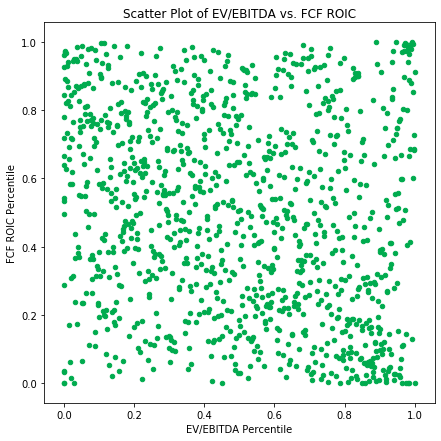

In [164]:
plt.figure(figsize=(7,7))
plt.scatter(b.EBITDAP.values, b.FCFROI.values, s=20, c=clr1[0])
plt.title("Scatter Plot of EV/EBITDA vs. FCF ROIC")
plt.xlabel('EV/EBITDA Percentile')
plt.ylabel('FCF ROIC Percentile')

plt.show()

### 4. K-Means Clustering


In [22]:
### test indexing data under multiindex framework

# a.index.names

#a[[29,73]]

a.loc[['2019-01-31'],('EBITDAP','FCFROI')]


FactorId                EBITDAP    FCFROI
Date       SecurityId                    
2019-01-31 00090Q10    0.040872  0.380995
           00163T10    0.711172  0.918552
           00164V10    0.013624  0.170136
           00287Y10    0.542234  0.095928
           00766T10    0.349682  0.353846
...                         ...       ...
           ZAYO        0.195277  0.663348
           ZBRA        0.623978  0.083258
           ZCVVV       0.960945  0.596833
           ZION        0.256131  0.370136
           ZMRH        0.628520  0.508597

[1114 rows x 2 columns]

In [23]:
# create data sample in array using 1/31/2019
dsamp = a.loc['2019-01-31',('EBITDAP','FCFROI')].values

# create kmeans object
kmeans = KMeans(n_clusters=8)
# fit kmeans object to data
kmeans.fit(dsamp)
# print location of clusters learned by kmeans object
print(kmeans.cluster_centers_)
# save new clusters for chart
y_km = kmeans.fit_predict(dsamp)

[[0.25533539 0.5199336 ]
 [0.85724563 0.83995515]
 [0.51750933 0.20837104]
 [0.11793667 0.82609455]
 [0.473363   0.79429018]
 [0.15384196 0.20476471]
 [0.71787478 0.47428253]
 [0.8440888  0.12847528]]


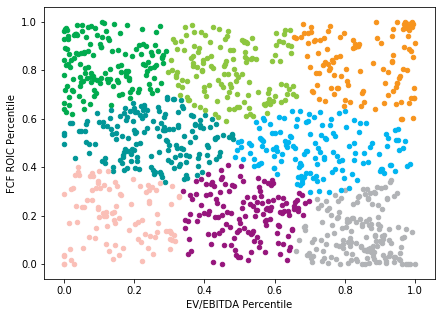

In [234]:
# Scatter plot the clusters
# note the color here is not the Cluster group #!!!

c_1901 = plt.figure(figsize=(7,5))

plt.scatter(dsamp[y_km ==0,0], dsamp[y_km == 0,1], s=20, c=clr2[0])
plt.scatter(dsamp[y_km ==1,0], dsamp[y_km == 1,1], s=20, c=clr2[1])
plt.scatter(dsamp[y_km ==2,0], dsamp[y_km == 2,1], s=20, c=clr2[2])
plt.scatter(dsamp[y_km ==3,0], dsamp[y_km == 3,1], s=20, c=clr2[3])
plt.scatter(dsamp[y_km ==4,0], dsamp[y_km == 4,1], s=20, c=clr2[4])
plt.scatter(dsamp[y_km ==5,0], dsamp[y_km == 5,1], s=20, c=clr2[5])
plt.scatter(dsamp[y_km ==6,0], dsamp[y_km == 6,1], s=20, c=clr2[6])
plt.scatter(dsamp[y_km ==7,0], dsamp[y_km == 7,1], s=20, c=clr2[7])

# plt.title("8-Means Clustering of EV/EBITDA vs. FCF ROIC - 01/31/2019")
plt.xlabel('EV/EBITDA Percentile')
plt.ylabel('FCF ROIC Percentile')

plt.show()

In [327]:
# fig2 = plty.Figure()
# fig2.add_trace(plty.Scatter(x=dsamp[y_km ==0,0], y=dsamp[y_km == 0,1], mode='markers',marker_color=clr2[0]))
# fig2.add_trace(plty.Scatter(x=dsamp[y_km ==1,0], y=dsamp[y_km == 1,1], mode='markers',marker_color=clr2[1]))
# fig2.add_trace(plty.Scatter(x=dsamp[y_km ==2,0], y=dsamp[y_km == 2,1], mode='markers',marker_color=clr2[2]))
# fig2.add_trace(plty.Scatter(x=dsamp[y_km ==3,0], y=dsamp[y_km == 3,1], mode='markers',marker_color=clr2[3]))
# fig2.add_trace(plty.Scatter(x=dsamp[y_km ==4,0], y=dsamp[y_km == 4,1], mode='markers',marker_color=clr2[4]))
# fig2.add_trace(plty.Scatter(x=dsamp[y_km ==5,0], y=dsamp[y_km == 5,1], mode='markers',marker_color=clr2[5]))
# fig2.add_trace(plty.Scatter(x=dsamp[y_km ==6,0], y=dsamp[y_km == 6,1], mode='markers',marker_color=clr2[6]))
# fig2.add_trace(plty.Scatter(x=dsamp[y_km ==7,0], y=dsamp[y_km == 7,1], mode='markers',marker_color=clr2[7]))
# fig2.update_layout(
#     title = 'Cluster Plot of EBITDAP vs. FCFROI',
#     yaxis_title = 'FCFROI Percentile',
#     xaxis_title = 'TTM EV/EBITDA Percentile'
# )
# fig2.show()

In [389]:
# create data sample in array using 1/31/2010
# cluster still looks similar, which indicates consistency of the pattern
dsamp2 = a.loc['2010-01-29',('EBITDAP','FCFROI')].values

# create kmeans object
kmeans2 = KMeans(n_clusters=8)
# fit kmeans object to data
kmeans2.fit(dsamp2)
# print location of clusters learned by kmeans object
print(kmeans2.cluster_centers_)
# save new clusters for chart
y_km2 = kmeans2.fit_predict(dsamp2)

[[0.15460317 0.5003812 ]
 [0.83431133 0.4943246 ]
 [0.84558514 0.85830491]
 [0.72910569 0.14328006]
 [0.46138345 0.77783027]
 [0.19310543 0.0954715 ]
 [0.47999661 0.35993703]
 [0.12789678 0.83098748]]


In [399]:
# print(kmeans2.cluster_centers_)
# kmeans2.cluster_centers_.transpose()
# np.lexsort(kmeans2.cluster_centers_.transpose())
# np.argsort(kmeans2.cluster_centers_.transpose())


[[0.83508191 0.48904254]
 [0.15380833 0.50163002]
 [0.48068699 0.78366154]
 [0.190964   0.09561929]
 [0.13662263 0.82984443]
 [0.85716981 0.85198376]
 [0.47933726 0.36138991]
 [0.72596305 0.14220883]]


array([[0.83508191, 0.15380833, 0.48068699, 0.190964  , 0.13662263,
        0.85716981, 0.47933726, 0.72596305],
       [0.48904254, 0.50163002, 0.78366154, 0.09561929, 0.82984443,
        0.85198376, 0.36138991, 0.14220883]])

In [343]:
# sc_data.Date.unique()

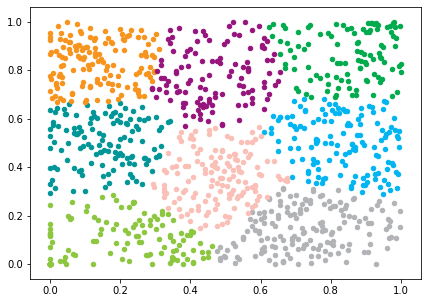

In [362]:
# Scatter plot the clusters

plt.figure(figsize=(7,5))
plt.scatter(dsamp2[y_km2 ==0,0], dsamp2[y_km2 == 0,1], s=20, c=clr2[0])
plt.scatter(dsamp2[y_km2 ==1,0], dsamp2[y_km2 == 1,1], s=20, c=clr2[1])
plt.scatter(dsamp2[y_km2 ==2,0], dsamp2[y_km2 == 2,1], s=20, c=clr2[2])
plt.scatter(dsamp2[y_km2 ==3,0], dsamp2[y_km2 == 3,1], s=20, c=clr2[3])
plt.scatter(dsamp2[y_km2 ==4,0], dsamp2[y_km2 == 4,1], s=20, c=clr2[4])
plt.scatter(dsamp2[y_km2 ==5,0], dsamp2[y_km2 == 5,1], s=20, c=clr2[5])
plt.scatter(dsamp2[y_km2 ==6,0], dsamp2[y_km2 == 6,1], s=20, c=clr2[6])
plt.scatter(dsamp2[y_km2 ==7,0], dsamp2[y_km2 == 7,1], s=20, c=clr2[7])

In [165]:
### check on some individual names to see whether there is any movements
# amzn, msft, ge, aapl, tsla

a.loc[a.index.get_level_values(1)=='AAPL',]
a.loc[a.index.get_level_values(1)=='AMZN',]
a.loc[a.index.get_level_values(1)=='GE',]
a.loc[a.index.get_level_values(1)=='CMB',] #JPM
a.loc[a.index.get_level_values(1)=='88160R10',] #TSLA
a.loc[a.index.get_level_values(1)=='G0624210',] #TEAM
a.loc[a.index.get_level_values(1)=='38259P70','BP'] #GOOG
a.loc[a.index.get_level_values(1)=='NTFZ',] #NFLX

dict_ticker = {
    '38259P70':'GOOG',
    'NTFZ':'NFLX',
    '88160R10':'TSLA',
    'CMB':'JPM'
}

seclist = ['AAPL','AMZN','GE','BA','CMB','88160R10','NTFZ','38259P70']

a_sub = a[a.index.get_level_values(1).isin(seclist)]

In [166]:
# update security name to tickers
a_sub.rename(index=dict_ticker, inplace=True)
a_sub

C:\Users\patrick.fang\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\frame.py:4238: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



FactorId               ActRtn12M  ActRtn3M        BP  ChgShare   EBITDAP  \
Date       SecurityId                                                      
2010-01-29 AAPL         0.103711  0.283019  0.858644  0.714012  0.744878   
           AMZN         0.110371  0.456604  0.961796  0.631478  0.843415   
           BA           0.646051  0.955660  0.979943  0.195777  0.624878   
           JPM          0.371075  0.067925  0.114613  0.790787  0.320000   
           GE           0.660324  0.717925  0.298949  0.808061  0.102927   
...                          ...       ...       ...       ...       ...   
2020-02-17 AMZN         0.648282  0.929141  0.892349  0.792705  0.829422   
           BA           0.870705  0.131975  0.973310  0.381673  0.916065   
           JPM          0.296564  0.550930  0.287367  0.145018  0.282491   
           GE           0.299277  0.712135  0.580961  0.639680  0.390794   
           NFLX         0.815552  0.959256  0.911922  0.682384  0.556859   

FactorId                 FCFROI  FF10MRtn      ROIC     TTMSP       GPM  
Date       SecurityId                                                    
2010-01-29 AAPL        0.035543  0.096099  0.092131  0.875717  0.630411  
           AMZN        0.010567  0.039962  0.081574  0.721797  0.826304  
           BA          0.975985  0.566127  0.338772  0.173996  0.892897  
           JPM         0.160423  0.259753  0.754319  0.466061  0.000000  
           GE          0.678194  0.612750  0.622841  0.366635  0.479467  
...                         ...       ...       ...       ...       ...  
2020-02-17 AMZN        0.076923  0.462511  0.281703  0.620107  0.553554  
           BA          0.995528  0.908762  0.876812  0.437722  0.946947  
           JPM         0.955277  0.145438  0.554348  0.548932  0.000000  
           GE          0.767442  0.415537  0.800725  0.198399  0.825826  
           NFLX        0.951699  0.829268  0.313406  0.849644  0.129129  

[917 rows x 10 columns]

In [167]:
a_sub.loc[a_sub.index.get_level_values(1)=='NFLX',('EBITDAP','FCFROI')]




,FactorId,EBITDAP,FCFROI
Date,SecurityId,,
2010-01-29,NFLX,0.407805,0.003842
2010-02-26,NFLX,0.441781,0.006731
2010-03-31,NFLX,0.488791,0.005764
2010-04-30,NFLX,0.600681,0.003831
2010-05-31,NFLX,0.739826,0.004780
...,...,...,...
2019-10-31,NFLX,0.500448,0.956289
2019-11-29,NFLX,0.518386,0.948260
2019-12-31,NFLX,0.515288,0.949062


Here we plot some individual names and see where they fall. For EBITDAP vs. ROIC, Interesting to see GE, BA,TSLA & TEAM & at the same right top corner (expense & not profitable)...

Now switching to EBITDA vs. FCFROI, many interesting movements:
GE from top right to top left (expensive to cheap)
TSLA from top right to middle right (low FCFROI to moderate FCFROI)
AAPL horizontally move from left to right (great FCFROI but more expensive)
BA jump from botton left to top left (737Max impact of its profitability)


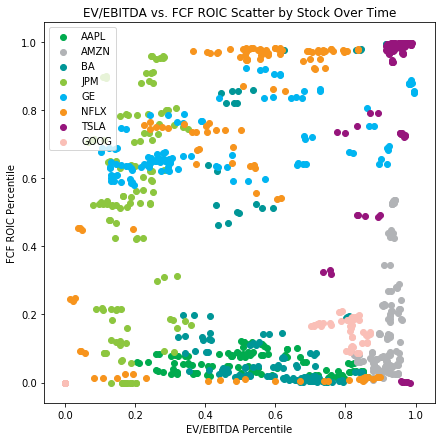

In [348]:
names = list(a_sub.index.get_level_values(1).unique())

# cmap = plt.get_cmap('viridis')
# colors = cmap(np.linspace(0, 1, len(names)))

plt.figure(figsize=(7,7))
for i, name in enumerate(names):
# for i, (name) in enumerate(zip(names), 1):
    # print(a_sub.loc[a_sub.index.get_level_values(1)==name,'EBITDAP'].values)
    plt.scatter(a_sub.loc[a_sub.index.get_level_values(1)==name,'EBITDAP'].values,
                a_sub.loc[a_sub.index.get_level_values(1)==name,'FCFROI'].values, 
                label=name
                ,c=clr2[i]
               )

plt.title("EV/EBITDA vs. FCF ROIC Scatter by Stock Over Time")
plt.xlabel('EV/EBITDA Percentile')
plt.ylabel('FCF ROIC Percentile')
plt.legend()
plt.show()



Here we will try to plot one name at a time, with colormap being the time, so we can see more clearly how the company moves around over time.

In [36]:
# functionize it

def factor_splot(x,y,clr):
    '''
    this function scatter plot two arrays (x & y) with the color map using clr value
    inputs type should be pandas Series
    '''
    plt.figure(figsize=(10,7))
    plt.scatter(x.values, y.values, c=clr.values, s=20, cmap='RdYlGn_r')
    cbar = plt.colorbar()
    cbar.set_label(f'{clr.name} Scale')
    plt.title(f"Scatter Plot of {x.name} vs. {y.name}")
    plt.xlabel(f'{x.name} Percentile')
    plt.ylabel(f'{y.name} Percentile')
    
    plt.show()


In [77]:
a_sub.loc[a_sub.index.get_level_values(1)=='NFLX',].index.get_level_values(0)


array([[0.        , 0.40784314, 0.21568627, 1.        ],
       [0.00799692, 0.42260669, 0.22337562, 1.        ],
       [0.01599385, 0.43737024, 0.23106498, 1.        ],
       [0.02399077, 0.45213379, 0.23875433, 1.        ],
       [0.0319877 , 0.46689735, 0.24644368, 1.        ],
       [0.03998462, 0.4816609 , 0.25413303, 1.        ],
       [0.05198001, 0.50380623, 0.26566705, 1.        ],
       [0.05997693, 0.51856978, 0.2733564 , 1.        ],
       [0.06797386, 0.53333333, 0.28104575, 1.        ],
       [0.07597078, 0.54809689, 0.2887351 , 1.        ],
       [0.0839677 , 0.56286044, 0.29642445, 1.        ],
       [0.09196463, 0.57762399, 0.3041138 , 1.        ],
       [0.10780469, 0.59892349, 0.31518647, 1.        ],
       [0.13118032, 0.61030373, 0.32103037, 1.        ],
       [0.15455594, 0.62168397, 0.32687428, 1.        ],
       [0.17793156, 0.63306421, 0.33271819, 1.        ],
       [0.20130719, 0.64444444, 0.33856209, 1.        ],
       [0.22468281, 0.65582468,

TypeError: colorbar() missing 1 required positional argument: 'mappable'

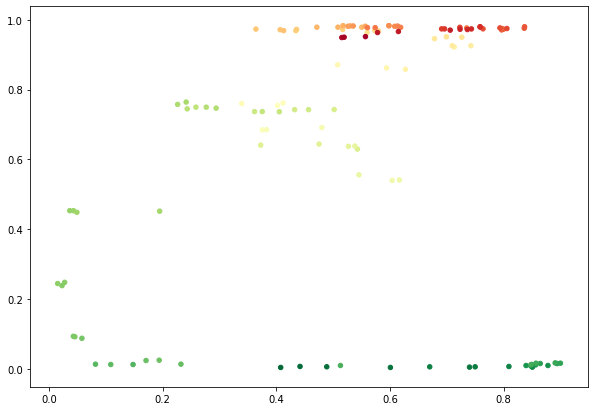

In [98]:
from matplotlib.dates import DateFormatter,DayLocator
from matplotlib import cm

# cmap = plt.get_cmap('RdYlGn_r')
# mycolors = cmap(np.linspace(0, 1, len(a_sub.loc[a_sub.index.get_level_values(1)=='NFLX',].index.get_level_values(0))))

plt.figure(figsize=(10,7))
# smap = 
plt.scatter(a_sub.loc[a_sub.index.get_level_values(1)=='NFLX','EBITDAP'].values,
                  a_sub.loc[a_sub.index.get_level_values(1)=='NFLX','FCFROI'].values, 
                  c = a_sub.loc[a_sub.index.get_level_values(1)=='NFLX',].index.get_level_values(0),
                  s=20
                  ,cmap='RdYlGn_r'
                 )

# cb = fig.colorbar(smap,orientation='vertical',shrink=0.7,
#                   ticks=DayLocator(interval=1000),
#                   format=DateFormatter('%Y-%m-%d'))

cbar = fig.colorbar()
cbar.set_label(f'Scale')


# plt.figure(figsize=(10,7))
# plt.scatter(d1901.EBITDAP.values, d1901.FCFROI.values, s=20, c=d1901.MRtRk.values, cmap='RdYlGn_r')
# cbar = plt.colorbar()
# cbar.set_label('Forward Month Return Rank Scale')
# plt.title("Scatter Plot of EV/EBITDA vs. FCF ROIC")
# plt.xlabel('EV/EBITDA Percentile')
# plt.ylabel('FCF ROIC Percentile')

plt.show()
# cbar.set_yticklabels(a_sub.loc[a_sub.index.get_level_values(1)=='NFLX',].index.get_level_values(0).strftime('%b %Y'))

In [45]:
factor_splot(a_sub.loc[a_sub.index.get_level_values(1)=='NFLX','EBITDAP'].values,
             a_sub.loc[a_sub.index.get_level_values(1)=='NFLX','FCFROI'].values, 
             a_sub.loc[a_sub.index.get_level_values(1)=='NFLX',].index.get_level_values(0)
            )

AttributeError: 'numpy.ndarray' object has no attribute 'values'

<Figure size 720x504 with 0 Axes>

### 5. Hierachical Clustering

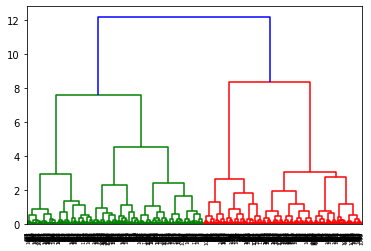

In [99]:
# create dendrogram
dendrogram = sch.dendrogram(sch.linkage(dsamp, method='ward'))
# create clusters
hc = AgglomerativeClustering(n_clusters=4, affinity = 'euclidean', linkage = 'ward')
# save clusters for chart
y_hc = hc.fit_predict(dsamp)

### 6. Create Monthly Cluster Groupings & map it back to original dataset

In [169]:
# pd.DataFrame({'Cluster':y_km}, index = a.loc[['2019-01-31 00:00:00']].index)
a.shape[0]

136718

In [170]:
# create an empty np array to store the cuslter prediction
c_pred = np.empty(0)

for i,d in enumerate(a.index.get_level_values(0).unique()):
    datai =  a.loc[d,('EBITDAP','FCFROI')].values
    
    # create kmeans object
    kmeans = KMeans(n_clusters=8)
    # fit kmeans object to data
    kmeans.fit(datai)
    # print location of clusters learned by kmeans object
    # print(kmeans.cluster_centers_)
    # save new clusters for chart
    c_pred = np.append(c_pred,kmeans.fit_predict(datai))
    
    # print (datai)
    # print (i)

c_pred.shape
    

(136718,)

In [291]:
# kmeans
kmeans.cluster_centers_
kmeans2.cluster_centers_

array([[0.47933726, 0.36138991],
       [0.13662263, 0.82984443],
       [0.83250091, 0.49170932],
       [0.19310543, 0.0954715 ],
       [0.85716981, 0.85198376],
       [0.72910569, 0.14328006],
       [0.47938512, 0.78511289],
       [0.15380833, 0.50163002]])

In [398]:


# # create data sample in array using 1/31/2019
# dsamp = a.loc['2019-01-31 00:00:00',('EBITDAP','FCFROI')].values

# # create kmeans object
# kmeans = KMeans(n_clusters=8)
# # fit kmeans object to data
# kmeans.fit(dsamp)
# # print location of clusters learned by kmeans object
# print(kmeans.cluster_centers_)
# # save new clusters for chart
# y_km = kmeans.fit_predict(dsamp)

In [309]:
c_pred_df['Cluster'].astype(str)

Date        SecurityId
2010-01-29  00163T10      3.0
            00184X10      5.0
            00766T10      2.0
            01527110      6.0
            01858110      6.0
                         ... 
2020-02-17  ZAYO          1.0
            ZBRA          3.0
            ZCVVV         7.0
            ZION          1.0
            ZMRH          0.0
Name: Cluster, Length: 136718, dtype: object

In [171]:
# assign the cluster groupping back to the orginal table
c_pred_df = pd.DataFrame({'Cluster':c_pred}, index = a.index)
a['Cluster'] = c_pred_df['Cluster']
a.head()

FactorId               ActRtn12M  ActRtn3M        BP  ChgShare   EBITDAP  \
Date       SecurityId                                                      
2010-01-29 00163T10     0.348240  0.682075  0.200573  0.975048  0.878049   
           00184X10     0.000000  0.000000  0.060172  0.000000  0.956098   
           00766T10     0.890580  0.468868  0.384909  0.816699  0.426829   
           01527110     0.843007  0.722642  0.202483  0.962572  0.341463   
           01858110     0.436727  0.578302  0.960840  0.006718  0.309756   

FactorId                 FCFROI  FF10MRtn      ROIC     TTMSP       GPM  \
Date       SecurityId                                                     
2010-01-29 00163T10    0.915466  0.547098  0.855086  0.910612  0.083241   
           00184X10    0.145053  0.000000  0.975048  0.221797  0.318535   
           00766T10    0.476465  0.888677  0.360845  0.106119  0.973363   
           01527110    0.910663  0.948620  0.729367  0.893881  0.117647   
           01858110    0.723343  0.394862  0.309021  0.599904  0.721976   

FactorId               Cluster  
Date       SecurityId           
2010-01-29 00163T10        3.0  
           00184X10        5.0  
           00766T10        2.0  
           01527110        6.0  
           01858110        6.0

### 7. Create Cluster Neutral Ranking

In [172]:
a['BP_CRank'] = a.groupby([a.index.get_level_values(0),'Cluster']).BP.rank(pct=True)
a['ActRtn12M_CRank'] = a.groupby([a.index.get_level_values(0),'Cluster']).ActRtn12M.rank(pct=True)
a.head()

FactorId               ActRtn12M  ActRtn3M        BP  ChgShare   EBITDAP  \
Date       SecurityId                                                      
2010-01-29 00163T10     0.348240  0.682075  0.200573  0.975048  0.878049   
           00184X10     0.000000  0.000000  0.060172  0.000000  0.956098   
           00766T10     0.890580  0.468868  0.384909  0.816699  0.426829   
           01527110     0.843007  0.722642  0.202483  0.962572  0.341463   
           01858110     0.436727  0.578302  0.960840  0.006718  0.309756   

FactorId                 FCFROI  FF10MRtn      ROIC     TTMSP       GPM  \
Date       SecurityId                                                     
2010-01-29 00163T10    0.915466  0.547098  0.855086  0.910612  0.083241   
           00184X10    0.145053  0.000000  0.975048  0.221797  0.318535   
           00766T10    0.476465  0.888677  0.360845  0.106119  0.973363   
           01527110    0.910663  0.948620  0.729367  0.893881  0.117647   
           01858110    0.723343  0.394862  0.309021  0.599904  0.721976   

FactorId               Cluster  BP_CRank  ActRtn12M_CRank  
Date       SecurityId                                      
2010-01-29 00163T10        3.0  0.216981         0.452830  
           00184X10        5.0  0.042424         0.012121  
           00766T10        2.0  0.165517         0.924138  
           01527110        6.0  0.191667         0.858333  
           01858110        6.0  0.966667         0.391667

(array([ 8.,  3.,  4.,  6.,  3.,  9., 15., 26., 33., 46.]),
 array([0.01028037, 0.10775701, 0.20523364, 0.30271028, 0.40018692,
        0.49766355, 0.59514019, 0.69261682, 0.79009346, 0.88757009,
        0.98504673]),
 <a list of 10 Patch objects>)

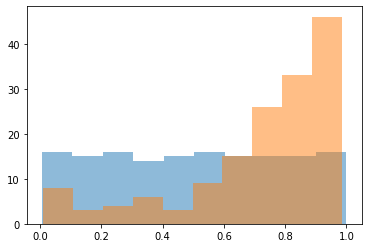

In [173]:
# some QA on the clustered rank
# looks good, the crank is unifrom for any cluster, while prank was not
test = a.loc[(a.index.get_level_values(0) == '2011-01-31 00:00:00') & (a.Cluster == 1),]['BP_CRank']
test1 = a.loc[(a.index.get_level_values(0) == '2011-01-31 00:00:00') & (a.Cluster == 1),]['BP']
plt.hist(test, alpha = 0.5)
plt.hist(test1, alpha = 0.5)

### 8. Getting security level return data and calc forward month return

In [176]:
# type(a.index.get_level_values(0).unique().format())

testDate = str(a.index.get_level_values(0).unique().format()).strip('[]')
testName = str(a.index.get_level_values(1).unique().format()).strip('[]')

f'IN ({testDate})'
f'IN ({testName})'
str(a.index.get_level_values(0).unique().format()).strip('[]')

"'2010-01-29', '2010-02-26', '2010-03-31', '2010-04-30', '2010-05-31', '2010-06-30', '2010-07-30', '2010-08-31', '2010-09-30', '2010-10-29', '2010-11-30', '2010-12-31', '2011-01-31', '2011-02-28', '2011-03-31', '2011-04-29', '2011-05-31', '2011-06-30', '2011-07-29', '2011-08-31', '2011-09-30', '2011-10-31', '2011-11-30', '2011-12-30', '2012-01-31', '2012-02-29', '2012-03-30', '2012-04-30', '2012-05-31', '2012-06-29', '2012-07-31', '2012-08-31', '2012-09-28', '2012-10-31', '2012-11-30', '2012-12-31', '2013-01-31', '2013-02-28', '2013-03-29', '2013-04-30', '2013-05-31', '2013-06-28', '2013-07-31', '2013-08-30', '2013-09-30', '2013-10-31', '2013-11-29', '2013-12-31', '2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30', '2014-05-30', '2014-06-30', '2014-07-31', '2014-08-29', '2014-09-30', '2014-10-31', '2014-11-28', '2014-12-31', '2015-01-30', '2015-02-27', '2015-03-31', '2015-04-30', '2015-05-29', '2015-06-30', '2015-07-31', '2015-08-31', '2015-09-30', '2015-10-30', '2015-11-30', '2015

In [177]:
DateList = str(a.index.get_level_values(0).unique().format()).strip('[]')

query = f'''SELECT SecurityId, TReturn, Date, Flag
FROM EquityResearch.dbo.ReturnsHistory rh
	INNER JOIN securitydb.dbo.SecurityMaster_Hist sm
		ON rh.IntegerId = sm.IntegerId
		AND rh.Date BETWEEN sm.StartDate AND sm.EndDate
AND rh.Date IN ({DateList})
ORDER BY rh.Date
'''

query

"SELECT SecurityId, TReturn, Date, Flag\nFROM EquityResearch.dbo.ReturnsHistory rh\n\tINNER JOIN securitydb.dbo.SecurityMaster_Hist sm\n\t\tON rh.IntegerId = sm.IntegerId\n\t\tAND rh.Date BETWEEN sm.StartDate AND sm.EndDate\nAND rh.Date IN ('2010-01-29', '2010-02-26', '2010-03-31', '2010-04-30', '2010-05-31', '2010-06-30', '2010-07-30', '2010-08-31', '2010-09-30', '2010-10-29', '2010-11-30', '2010-12-31', '2011-01-31', '2011-02-28', '2011-03-31', '2011-04-29', '2011-05-31', '2011-06-30', '2011-07-29', '2011-08-31', '2011-09-30', '2011-10-31', '2011-11-30', '2011-12-30', '2012-01-31', '2012-02-29', '2012-03-30', '2012-04-30', '2012-05-31', '2012-06-29', '2012-07-31', '2012-08-31', '2012-09-28', '2012-10-31', '2012-11-30', '2012-12-31', '2013-01-31', '2013-02-28', '2013-03-29', '2013-04-30', '2013-05-31', '2013-06-28', '2013-07-31', '2013-08-30', '2013-09-30', '2013-10-31', '2013-11-29', '2013-12-31', '2014-01-31', '2014-02-28', '2014-03-31', '2014-04-30', '2014-05-30', '2014-06-30', '20

In [178]:
ret = pd.read_sql_query(query,conn)
ret.shape

(251041, 4)

In [179]:
ret.head()

,SecurityId,TReturn,Date,Flag
0,AYSI,1.706667e+02,2019-01-31,2
1,ALT,6.956522e-08,2019-01-31,2
2,WMC,8.745682e+01,2019-01-31,0
3,DIT,6.932260e+02,2019-01-31,2
4,TMBE,4.266240e-10,2019-01-31,0


In [761]:
type(universe)

pandas.core.frame.DataFrame

In [180]:
# join to unique security list to form a smaller subset
universe = pd.DataFrame({'SecurityId':a.index.get_level_values(1).unique().format()})
universe

uni_ret = pd.merge(ret, universe, how='inner', on=['SecurityId']).sort_values(['SecurityId','Date'])
uni_ret.reset_index(drop=True, inplace=True)

uni_ret['MRet'] = uni_ret.groupby(['SecurityId']).TReturn.pct_change().shift(periods=-1)*100
uni_ret['QRet'] = uni_ret.groupby(['SecurityId']).TReturn.pct_change(3).shift(periods=-3)*100
uni_ret['HYRet'] = uni_ret.groupby(['SecurityId']).TReturn.pct_change(6).shift(periods=-6)*100
uni_ret['YRet'] = uni_ret.groupby(['SecurityId']).TReturn.pct_change(12).shift(periods=-12)*100
uni_ret

,SecurityId,TReturn,Date,Flag,MRet,QRet,HYRet,YRet
0,00090Q10,59.291279,2019-01-31,0,10.803338,-8.235779,-11.072877,-5.057135
1,00090Q10,65.696716,2019-02-28,0,-20.125003,-26.482458,-39.839049,NaN
2,00090Q10,52.475250,2019-03-29,0,3.683508,-3.161455,-0.214007,NaN
3,00090Q10,54.408180,2019-04-30,0,-11.229138,-3.091726,18.804612,NaN
4,00090Q10,48.298611,2019-05-31,0,5.212693,-18.167896,59.769504,NaN
...,...,...,...,...,...,...,...,...
18078,ZMRH,494.035614,2019-09-30,0,0.699340,9.214674,NaN,NaN
18079,ZMRH,497.490601,2019-10-31,0,5.100194,7.166423,NaN,NaN
18080,ZMRH,522.863586,2019-11-29,0,3.193147,NaN,NaN,NaN
18081,ZMRH,539.559387,2019-12-31,0,-1.189212,NaN,NaN,NaN


In [181]:
# uni_ret['Date'] = uni_ret['Date']+' 00:00:00'
# uni_ret.head()
ret_f = uni_ret.set_index(['Date','SecurityId'])
ret_f.head()

,,TReturn,Flag,MRet,QRet,HYRet,YRet
Date,SecurityId,,,,,,
2019-01-31,00090Q10,59.291279,0,10.803338,-8.235779,-11.072877,-5.057135
2019-02-28,00090Q10,65.696716,0,-20.125003,-26.482458,-39.839049,NaN
2019-03-29,00090Q10,52.475250,0,3.683508,-3.161455,-0.214007,NaN
2019-04-30,00090Q10,54.408180,0,-11.229138,-3.091726,18.804612,NaN
2019-05-31,00090Q10,48.298611,0,5.212693,-18.167896,59.769504,NaN


In [182]:
a.index
# ret_f.index

MultiIndex([('2010-01-29', '00163T10'),
            ('2010-01-29', '00184X10'),
            ('2010-01-29', '00766T10'),
            ('2010-01-29', '01527110'),
            ('2010-01-29', '01858110'),
            ('2010-01-29', '03042010'),
            ('2010-01-29', '03097510'),
            ('2010-01-29', '03571040'),
            ('2010-01-29', '03674B10'),
            ('2010-01-29', '03739T10'),
            ...
            ('2020-02-17',      'YRI'),
            ('2020-02-17',      'YUM'),
            ('2020-02-17',   'YUMCWI'),
            ('2020-02-17',        'Z'),
            ('2020-02-17',      'ZAP'),
            ('2020-02-17',     'ZAYO'),
            ('2020-02-17',     'ZBRA'),
            ('2020-02-17',    'ZCVVV'),
            ('2020-02-17',     'ZION'),
            ('2020-02-17',     'ZMRH')],
           names=['Date', 'SecurityId'], length=136718)

In [183]:
# making sure the index of date matches in two df
# a.index.get_level_values(0) = 
# a.index.get_level_values(0).format()
type(a.index.get_level_values(0)) #pandas.core.indexes.base.Index
type(ret_f.index.get_level_values(0)) #pandas.core.indexes.datetimes.DatetimeIndex

pandas.core.indexes.datetimes.DatetimeIndex

### 9. Aggregate return to monthly and calc decile spread time series

In [184]:
fd = pd.merge(a, ret_f, how='inner', left_index=True, right_index=True)
# a.join(ret_f)

In [185]:
fd.index.get_level_values(0).max()
fd.head()

ActRtn12M  ActRtn3M        BP  ChgShare   EBITDAP  \
Date       SecurityId                                                      
2019-07-31 MCD          0.142599  0.728559  0.969163  0.276292  0.689286   
           RGLD         0.413357  0.982317  0.548018  0.587344  0.832143   
           MGA          0.773466  0.183024  0.198238  0.038324  0.061607   
2019-12-31 COG          0.946703  0.248453  0.503993  0.108252  0.107014   
2019-06-28 69743510     0.459002  0.075850  0.860485  0.841921  0.910448   

                         FCFROI  FF10MRtn      ROIC     TTMSP       GPM  \
Date       SecurityId                                                     
2019-07-31 MCD         0.518190  0.109107  0.077887  0.851101  0.450000   
           RGLD        0.416149  0.382326  0.771710  0.962115  0.178431   
           MGA         0.257320  0.867448  0.162936  0.045815  0.971569   
2019-12-31 COG         0.183199  0.903517  0.094118  0.577640  0.319361   
2019-06-28 69743510    0.022707  0.224000  0.900353  0.835355  0.262248   

                       Cluster  BP_CRank  ActRtn12M_CRank       TReturn  Flag  \
Date       SecurityId                                                           
2019-07-31 MCD             2.0  0.985915         0.260563  59001.050781     0   
           RGLD            2.0  0.387324         0.605634   4889.445801     0   
           MGA             5.0  0.298851         0.701149   2993.496094     0   
2019-12-31 COG             6.0  0.715686         0.960784   1469.472046     0   
2019-06-28 69743510        4.0  0.583333         0.816667    383.512085     0   

                            MRet      QRet      HYRet  YRet  
Date       SecurityId                                        
2019-07-31 MCD          3.991077 -6.156604   2.738848   NaN  
           RGLD        16.539980  1.078405   1.206771   NaN  
           MGA          0.133289  7.446939   1.979854   NaN  
2019-12-31 COG        -18.538086       NaN        NaN   NaN  
2019-06-28 69743510    11.179832  0.034368  13.491368   NaN

In [186]:
fd['HML_Decile'] = np.ceil(fd.BP_CRank*10).astype(int) #.astype(str)
fd['MOM_Decile'] = np.ceil(fd.ActRtn12M_CRank*10).astype(int) #.astype(str)

In [187]:
fd.tail()
fd[fd.HML_Decile == 10]
fd.HML_Decile.unique()
fd.MOM_Decile.unique()
# fd.BP_CRank.describe()

array([ 3,  7,  8, 10,  9,  4,  1,  6,  5,  2], dtype=int64)

In [188]:
MthDcl_HML = pd.DataFrame({'Ret':fd.groupby([fd.index.get_level_values(0),fd.HML_Decile]).MRet.mean()}).reset_index()
MthDcl_MOM = pd.DataFrame({'Ret':fd.groupby([fd.index.get_level_values(0),fd.MOM_Decile]).MRet.mean()}).reset_index()

type(MthDcl_HML)

pandas.core.frame.DataFrame

In [189]:
MthDcl_HML = MthDcl_HML[MthDcl_HML.Date != '2020-01-31']
MthDcl_MOM = MthDcl_MOM[MthDcl_MOM.Date != '2020-01-31']

In [190]:
MthDcl_HML = MthDcl_HML.pivot(index='Date', columns='HML_Decile', values='Ret')
MthDcl_MOM = MthDcl_MOM.pivot(index='Date', columns='MOM_Decile', values='Ret')

In [191]:
MthDcl_HML['Spread'] = MthDcl_HML[1] - MthDcl_HML[10]
MthDcl_MOM['Spread'] = MthDcl_MOM[1] - MthDcl_MOM[10]

In [193]:
MthDcl_HML['Cum1'] = np.cumprod(1+MthDcl_HML[1]/100)
MthDcl_HML['Cum10'] = np.cumprod(1+MthDcl_HML[10]/100)
MthDcl_HML['CumSprd'] = np.cumprod(1+MthDcl_HML['Spread']/100)
MthDcl_MOM['Cum1'] = np.cumprod(1+MthDcl_MOM[1]/100)
MthDcl_MOM['Cum10'] = np.cumprod(1+MthDcl_MOM[10]/100)
MthDcl_MOM['CumSprd'] = np.cumprod(1+MthDcl_MOM['Spread']/100)

In [194]:
MthDcl_HML
# MthDcl_MOM

HML_Decile,1,2,3,4,5,6,7,8,9,10,Spread,Cum1,Cum10,CumSprd
Date,,,,,,,,,,,,,,
2019-01-31,2.723630,3.623692,2.530861,3.454209,4.326197,4.501946,5.613959,3.122082,5.079566,5.180569,-2.456939,1.027236,1.051806,0.975431
2019-02-28,-1.404039,-0.379432,-0.412126,1.271129,-0.305520,1.409219,1.093100,0.778914,1.952155,-0.335931,-1.068108,1.012814,1.048272,0.965012
2019-03-29,5.735434,4.282436,3.271323,4.074192,3.411919,2.531480,2.003231,2.975110,5.316965,2.482673,3.252761,1.070903,1.074298,0.996401
2019-04-30,-9.828889,-5.808542,-7.326812,-5.963262,-6.487371,-7.349151,-7.255426,-6.255567,-6.005937,-7.133941,-2.694948,0.965645,0.997658,0.969549
2019-05-31,7.733647,6.771362,7.377932,6.878621,7.235780,5.908621,8.018275,7.842157,7.587209,5.249510,2.484138,1.040324,1.050030,0.993634
2019-06-28,0.144805,1.494298,1.650702,1.268804,-0.226156,-0.313330,1.576420,1.314692,1.455190,2.198051,-2.053246,1.041831,1.073110,0.973232
2019-07-31,-7.513166,-4.739671,-4.870038,-2.830546,-3.958756,-4.565731,-2.574345,-2.994727,-2.684865,-2.464460,-5.048706,0.963556,1.046664,0.924097
2019-08-30,5.876540,4.574650,3.366595,3.270668,2.441613,2.487686,1.197364,1.651331,0.195494,-0.845617,6.722158,1.020180,1.037813,0.986216
2019-09-30,-2.054772,0.811632,0.670496,0.691788,0.336642,1.661206,0.460649,2.237303,1.621825,0.383512,-2.438284,0.999218,1.041793,0.962169


In [195]:
MthDcl_MOM

MOM_Decile,1,2,3,4,5,6,7,8,9,10,Spread,Cum1,Cum10,CumSprd
Date,,,,,,,,,,,,,,
2019-01-31,5.032088,4.075565,4.105849,3.239316,3.565737,4.150220,2.894023,3.069637,4.895742,5.159293,-0.127205,1.050321,1.051593,0.998728
2019-02-28,-0.524711,1.153411,1.457943,0.658122,-0.214048,0.254153,0.599809,0.073314,-0.190422,0.342671,-0.867383,1.044810,1.055196,0.990065
2019-03-29,1.931484,2.618013,1.849015,3.398363,3.748320,4.234746,4.792511,4.487910,4.156378,4.657193,-2.725709,1.064990,1.104339,0.963079
2019-04-30,-6.489184,-2.524020,-3.809488,-4.844303,-6.349705,-6.256612,-7.501437,-7.985192,-10.269919,-13.098336,6.609152,0.995881,0.959689,1.026730
2019-05-31,5.645733,6.066111,6.943398,6.535054,6.509103,5.844323,8.207424,8.487240,7.804715,8.397043,-2.751310,1.052106,1.040274,0.998482
2019-06-28,1.495445,2.159677,0.672712,0.818492,1.073668,1.765049,1.588019,1.366090,0.004104,-0.236348,1.731792,1.067839,1.037816,1.015773
2019-07-31,-2.997459,-0.021974,-1.567350,-2.283217,-1.309368,-2.733892,-2.708861,-4.758450,-8.456704,-11.863315,8.865856,1.035831,0.914696,1.105830
2019-08-30,-3.382545,-0.877983,0.899332,2.646441,2.869939,2.670280,2.827860,4.865673,4.928753,6.346540,-9.729084,1.000794,0.972748,0.998243
2019-09-30,0.772845,-0.368967,1.587465,1.011276,1.246899,0.268984,0.896051,1.190457,0.807337,-0.426558,1.199403,1.008528,0.968599,1.010216


In [620]:
MthDcl.to_csv(path.join(sc_path,'clusterOutput.txt'), sep='\t')

### 10. More experiements
1. try coloring the scatter plot by forward reutrn
2. try coloring the sactter plot by cross sectional BP factor value
3. so what are the return distribution for each cluster?
4. try to use multiple factors to construct a avg Valuation factor & a avg 

In [196]:
fd.head()
# fd.shape
fd['MRtRk'] = fd.groupby([fd.index.get_level_values(0)]).MRet.rank(pct=True, ascending=False) #default asc, thus negative one being the top rank
fd['QRtRk'] = fd.groupby([fd.index.get_level_values(0)]).QRet.rank(pct=True, ascending=False) #default asc, thus negative one being the top rank
fd['HYRtRk'] = fd.groupby([fd.index.get_level_values(0)]).HYRet.rank(pct=True, ascending=False) #default asc, thus negative one being the top rank
fd['YRtRk'] = fd.groupby([fd.index.get_level_values(0)]).YRet.rank(pct=True, ascending=False) #default asc, thus negative one being the top rank



In [328]:
d1901 = fd.loc[fd.index.get_level_values(0) == '2019-01-31',]
# d1901["Cluster"] = d1901["Cluster"].astype(str)

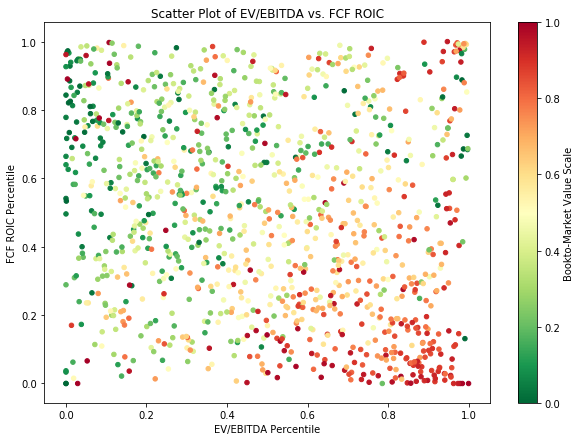

In [198]:
# color using BP rank
plt.figure(figsize=(10,7))
plt.scatter(d1901.EBITDAP.values, d1901.FCFROI.values, s=20, c=d1901.BP.values, cmap='RdYlGn_r')
cbar = plt.colorbar()
cbar.set_label('Bookto-Market Value Scale')
plt.title("Scatter Plot of EV/EBITDA vs. FCF ROIC")
plt.xlabel('EV/EBITDA Percentile')
plt.ylabel('FCF ROIC Percentile')

plt.show()

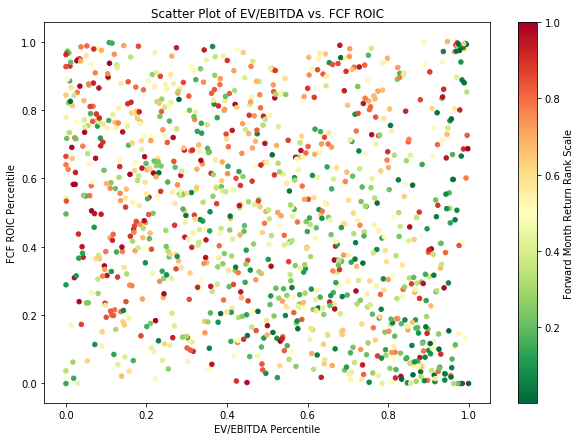

In [199]:
# color using foward return

plt.figure(figsize=(10,7))
plt.scatter(d1901.EBITDAP.values, d1901.FCFROI.values, s=20, c=d1901.MRtRk.values, cmap='RdYlGn_r')
cbar = plt.colorbar()
cbar.set_label('Forward Month Return Rank Scale')
plt.title("Scatter Plot of EV/EBITDA vs. FCF ROIC")
plt.xlabel('EV/EBITDA Percentile')
plt.ylabel('FCF ROIC Percentile')

plt.show()

In [200]:
# functionize it

def factor_splot(x,y,clr):
    # this function scatter plot two arrays (x & y) with the color map using clr value
    # inputs type should be pandas Series
    plt.figure(figsize=(10,7))
    plt.scatter(x.values, y.values, c=clr.values, s=20, cmap='RdYlGn_r')
    cbar = plt.colorbar()
    cbar.set_label(f'{clr.name} Scale')
    plt.title(f"Scatter Plot of {x.name} vs. {y.name}")
    plt.xlabel(f'{x.name} Percentile')
    plt.ylabel(f'{y.name} Percentile')
    
    plt.show()


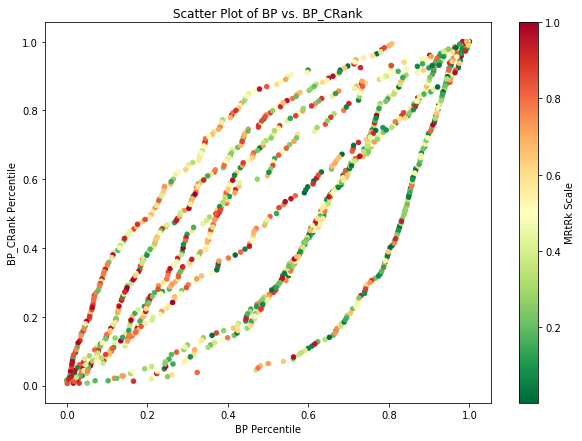

In [201]:
# factor_splot(x = d1901.BP, y = d1901.EBITDAP, clr=d1901.MRtRk)
factor_splot(x = d1901.BP, y = d1901.BP_CRank, clr=d1901.MRtRk)

Text(0.5, 1.0, 'Return Distribution by Cluster')

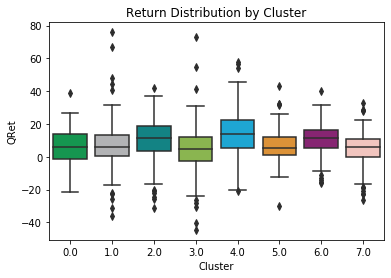

In [329]:
# Return distribution (boxplot) for each cluster

sns.boxplot(x = 'Cluster', y = 'QRet', data = d1901, palette = clr2)
plt.title(f"Return Distribution by Cluster")

Text(0.5, 1.0, 'Forward Month Return Distribution by Cluster')

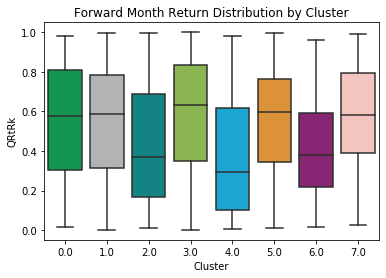

In [337]:
sns.boxplot(x = 'Cluster', y = 'MRtRk', data = d1901, palette = clr2)
plt.title(f"Forward Month Return Distribution by Cluster")


Text(0.5, 1.0, 'Forward Quarter Return Distribution by Cluster')

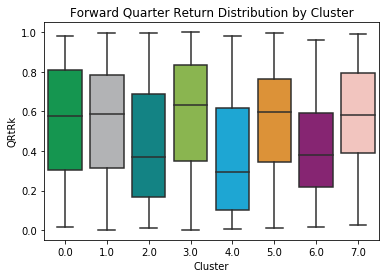

In [338]:
sns.boxplot(x = 'Cluster', y = 'QRtRk', data = d1901, palette = clr2)
plt.title(f"Forward Quarter Return Distribution by Cluster")

Text(0.5, 1.0, 'Forward 6M Return Distribution by Cluster')

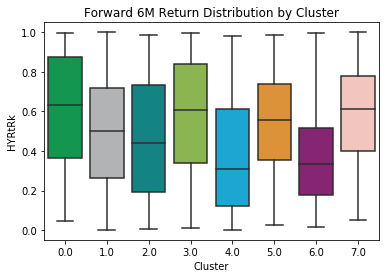

In [340]:
sns.boxplot(x = 'Cluster', y = 'HYRtRk', data = d1901, palette = clr2)
plt.title(f"Forward 6M Return Distribution by Cluster")

Text(0.5, 1.0, 'Forward Year Return Distribution by Cluster')

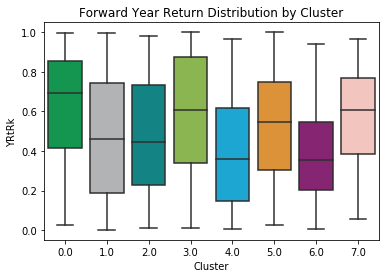

In [339]:
sns.boxplot(x = 'Cluster', y = 'YRtRk', data = d1901, palette = clr2)
plt.title(f"Forward Year Return Distribution by Cluster")

Interestingly, the top performers are from 2, 4 & 6 clusters. Compared this to the cluster scatter plot, we see they are the bottom middle, bottom right & middle right sections... basically the lower right corner... (combination of "expensive" & profitable)!

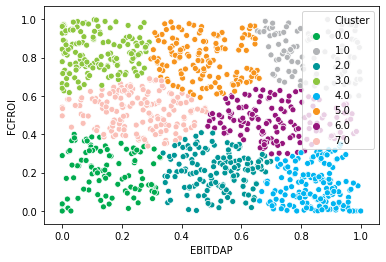

In [335]:
sns.scatterplot(x="EBITDAP",y="FCFROI",hue="Cluster",data=d1901,
               palette={0.0:clr2[0],1.0:clr2[1],2.0:clr2[2],3.0:clr2[3],
                          4.0:clr2[4],5.0:clr2[5],6.0:clr2[6],7.0:clr2[7]}
               )

Next, try to plot subplots by Cluster & HML_Decile grouping,

scatter of forward return vs. some factor??

[BP_CRank vs. MRtRk Reggression Plot by Cluster]
Elapsed: 3.7696077823638916


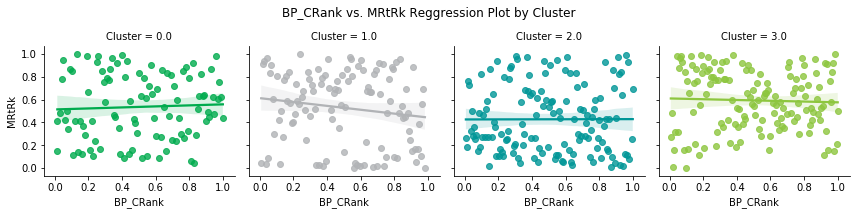

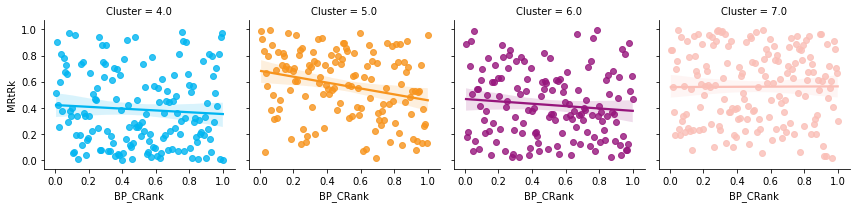

In [330]:
# with Timer('Cluster Decile'):
#     g = sns.FacetGrid(d1901[(d1901.Cluster.isin([0.0,4.0])) & (d1901.HML_Decile.isin([1,10]))], 
#                              col="Cluster", row="HML_Decile", margin_titles=True)
#     g.map(sns.regplot, "BP_CRank","MRtRk")

with Timer('BP_CRank vs. MRtRk Reggression Plot by Cluster'):
    g = sns.FacetGrid(d1901[(d1901.Cluster.isin(['0.0','1.0','2.0','3.0']))], 
                      col="Cluster", # row="HML_Decile", 
                      hue = "Cluster",
                      palette=clr2,
                      margin_titles=True)
    g.map(sns.regplot, "BP_CRank","MRtRk")
    plt.subplots_adjust(top=0.8)
    g.fig.suptitle('BP_CRank vs. MRtRk Reggression Plot by Cluster')
    g = sns.FacetGrid(d1901[(d1901.Cluster.isin(['4.0','5.0','6.0','7.0']))], 
                      col="Cluster", # row="HML_Decile", 
                      hue = "Cluster",
                      palette=clr2[4:],
                      margin_titles=True)
    g.map(sns.regplot, "BP_CRank","MRtRk")

[BP_CRank vs. QRtRk Reggression Plot by Cluster]
Elapsed: 2.395026206970215


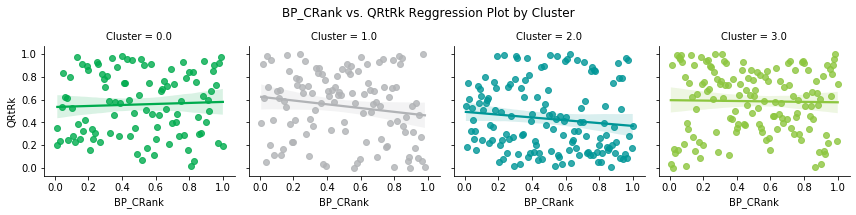

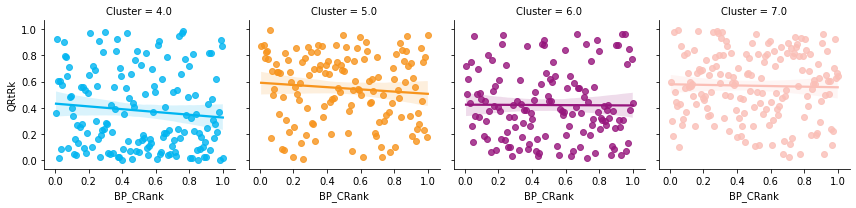

In [277]:
with Timer('BP_CRank vs. QRtRk Reggression Plot by Cluster'):
    g = sns.FacetGrid(d1901[(d1901.Cluster.isin([0.0,1.0,2.0,3.0]))], 
                      col="Cluster", # row="HML_Decile", 
                      hue = "Cluster",
                      palette=clr2,
                      margin_titles=True)
    g.map(sns.regplot, "BP_CRank","QRtRk")
    plt.subplots_adjust(top=0.8)
    g.fig.suptitle('BP_CRank vs. QRtRk Reggression Plot by Cluster')
    g = sns.FacetGrid(d1901[(d1901.Cluster.isin(['4.0','5.0','6.0','7.0']))], 
                      col="Cluster", # row="HML_Decile", 
                      hue = "Cluster",
                      palette=clr2[4:],
                      margin_titles=True)
    g.map(sns.regplot, "BP_CRank","QRtRk")

[BP_CRank vs. YRtRk Reggression Plot by Cluster]
Elapsed: 2.605015993118286


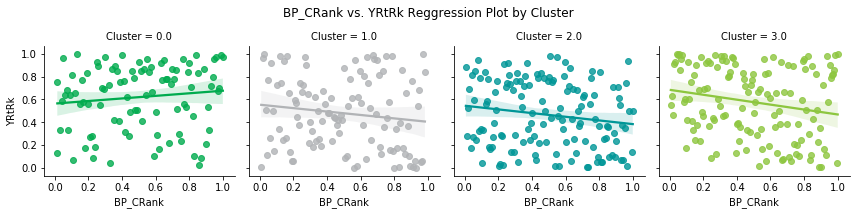

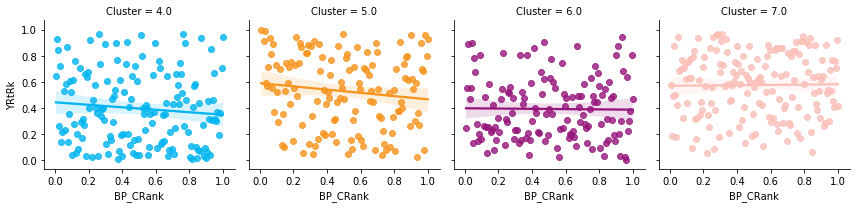

In [316]:
with Timer('BP_CRank vs. YRtRk Reggression Plot by Cluster'):
    g = sns.FacetGrid(d1901[(d1901.Cluster.isin(['0.0','1.0','2.0','3.0']))], 
                      col="Cluster", # row="HML_Decile", 
                      hue = "Cluster",
                      palette=clr2,
                      margin_titles=True)
    g.map(sns.regplot, "BP_CRank","YRtRk")
    plt.subplots_adjust(top=0.8)
    g.fig.suptitle('BP_CRank vs. YRtRk Reggression Plot by Cluster')
    g = sns.FacetGrid(d1901[(d1901.Cluster.isin(['4.0','5.0','6.0','7.0']))], 
                      col="Cluster", # row="HML_Decile", 
                      hue = "Cluster",
                      palette=clr2[4:],
                      margin_titles=True)
    g.map(sns.regplot, "BP_CRank","YRtRk")

So it looks like cluster 0 (bottom left, or cheap & "profitable" ones) are working (positive slope) for all month, quarter & year forward return.

How about such cluster over time, check monthly return??

For this question, we first need to identify manually which cluster is such one in each month. This is because KMeans randomly assign cluster # to each group and cluster 0 doesn't mean the same group over time.

In [403]:
fd.index.get_level_values(0).unique().sort_values()

# fd.loc[fd.index.get_level_values(0) == '2019-01-31']

# sns.scatterplot(x="EBITDAP",y="FCFROI",hue="Cluster",data=d1901,
#                palette={0.0:clr2[0],1.0:clr2[1],2.0:clr2[2],3.0:clr2[3],
#                           4.0:clr2[4],5.0:clr2[5],6.0:clr2[6],7.0:clr2[7]}
#                )



DatetimeIndex(['2019-01-31', '2019-02-28', '2019-03-29', '2019-04-30',
               '2019-05-31', '2019-06-28', '2019-07-31', '2019-08-30',
               '2019-09-30', '2019-10-31', '2019-11-29', '2019-12-31',
               '2020-01-31'],
              dtype='datetime64[ns]', name='Date', freq=None)

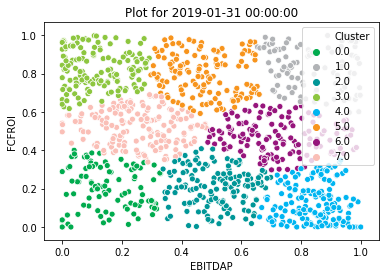

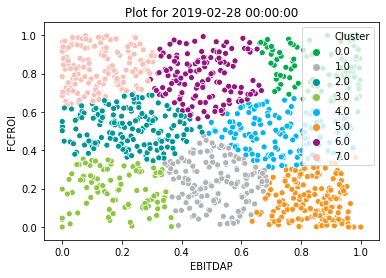

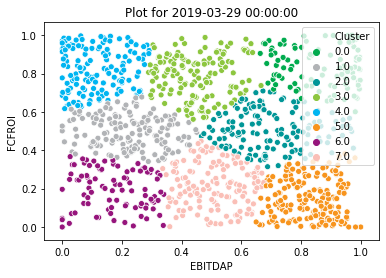

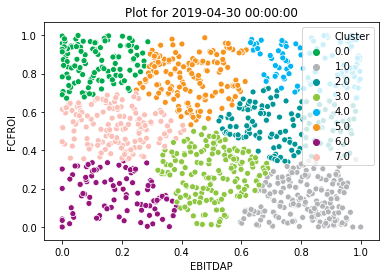

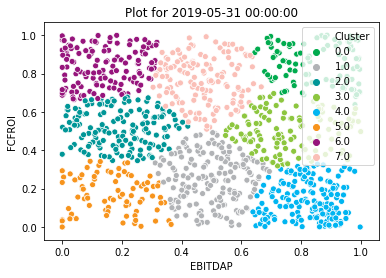

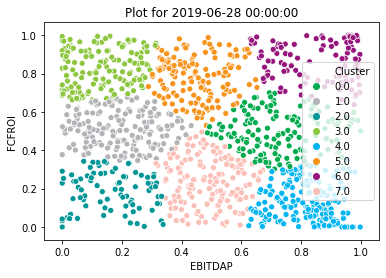

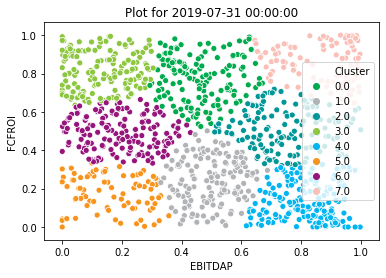

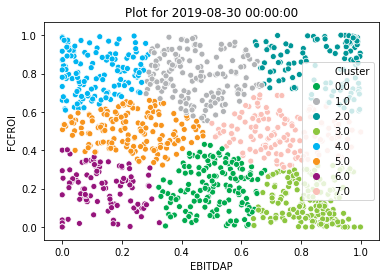

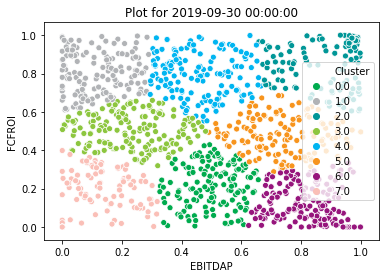

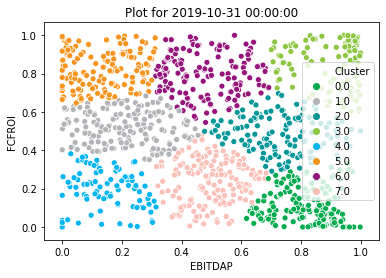

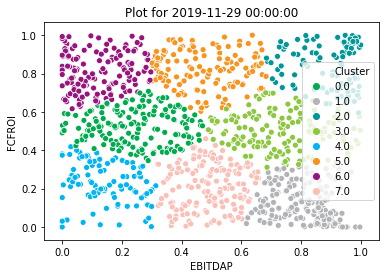

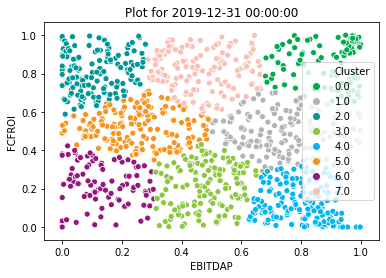

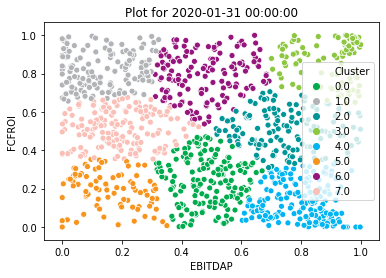

In [347]:
for i,d in enumerate(fd.index.get_level_values(0).unique().sort_values()):
    subset = fd.loc[fd.index.get_level_values(0) == d]
    
    plt.figure(i)
    sns.scatterplot(x="EBITDAP",y="FCFROI",hue="Cluster",data=subset,
                    palette={0.0:clr2[0],1.0:clr2[1],2.0:clr2[2],3.0:clr2[3],
                             4.0:clr2[4],5.0:clr2[5],6.0:clr2[6],7.0:clr2[7]}
                   ).set_title(f'Plot for {d}')

In [411]:
fd.index.get_level_values(0).unique().sort_values()

DatetimeIndex(['2019-01-31', '2019-02-28', '2019-03-29', '2019-04-30',
               '2019-05-31', '2019-06-28', '2019-07-31', '2019-08-30',
               '2019-09-30', '2019-10-31', '2019-11-29', '2019-12-31',
               '2020-01-31'],
              dtype='datetime64[ns]', name='Date', freq=None)

In [462]:
# select value trap manually

valueCorner = fd.loc[((fd.index.get_level_values(0) == '2019-01-31') & (fd.Cluster == 0.0)) |
       ((fd.index.get_level_values(0) == '2019-02-28') & (fd.Cluster == 3.0)) |
       ((fd.index.get_level_values(0) == '2019-03-29') & (fd.Cluster == 6.0)) |
       ((fd.index.get_level_values(0) == '2019-04-30') & (fd.Cluster == 6.0)) |
       ((fd.index.get_level_values(0) == '2019-05-31') & (fd.Cluster == 5.0)) |
       ((fd.index.get_level_values(0) == '2019-06-28') & (fd.Cluster == 2.0)) |
       ((fd.index.get_level_values(0) == '2019-07-31') & (fd.Cluster == 5.0)) |
       ((fd.index.get_level_values(0) == '2019-08-30') & (fd.Cluster == 6.0)) |
       ((fd.index.get_level_values(0) == '2019-09-30') & (fd.Cluster == 7.0)) |
       ((fd.index.get_level_values(0) == '2019-10-31') & (fd.Cluster == 4.0)) |
       ((fd.index.get_level_values(0) == '2019-11-29') & (fd.Cluster == 4.0)) |
       ((fd.index.get_level_values(0) == '2019-12-31') & (fd.Cluster == 6.0))
      ]

valueCorner.reset_index(inplace=True)
valueCorner['Mth'] = pd.to_datetime(valueCorner['Date']).dt.to_period('M')

C:\Users\patrick.fang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [463]:
valueCorner.sort_values(by=['Date','SecurityId'], inplace=True)
valueCorner.reset_index(inplace=True, drop=True)

C:\Users\patrick.fang\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [464]:
valueCorner.head()

,Date,SecurityId,ActRtn12M,ActRtn3M,BP,ChgShare,EBITDAP,FCFROI,FF10MRtn,ROIC,...,QRet,HYRet,YRet,HML_Decile,MOM_Decile,MRtRk,QRtRk,HYRtRk,YRtRk,Mth
0,2019-01-31,00090Q10,0.000000,0.210621,0.153777,0.801095,0.040872,0.380995,0.942962,0.742674,...,-8.235779,-11.072877,-5.057135,2,1,0.122283,0.914390,0.878093,0.772093,2019-01
1,2019-01-31,00164V10,0.280702,0.730873,0.881295,0.028285,0.013624,0.170136,0.160994,0.195055,...,-7.197298,-15.189036,-41.865238,10,2,0.472826,0.904372,0.908341,0.957209,2019-01
2,2019-01-31,01858110,0.908587,0.079208,0.642086,0.341241,0.099909,0.193665,0.793928,0.587912,...,-9.520982,-10.925593,-41.006154,8,9,0.847826,0.931694,0.875344,0.954419,2019-01
3,2019-01-31,01973R10,0.275162,0.819082,0.838129,0.036496,0.244323,0.115837,0.301748,0.161172,...,-3.423833,-4.974162,-7.986311,10,2,0.621377,0.850638,0.796517,0.794419,2019-01
4,2019-01-31,03571040,0.587258,0.677768,0.096223,0.965328,0.038147,0.172851,0.473781,0.128205,...,-0.470352,-3.209016,4.449215,1,4,0.871377,0.797814,0.766269,0.639070,2019-01


In [465]:
# type(valueCorner.Date.unique())
dlist = sorted(valueCorner.Mth.unique())
dlist[:6]
# dlist[-6:]


[Period('2019-01', 'M'),
 Period('2019-02', 'M'),
 Period('2019-03', 'M'),
 Period('2019-04', 'M'),
 Period('2019-05', 'M'),
 Period('2019-06', 'M')]

[BP_CRank vs. MRtRk Reggression Plot for Value Cluster by Month]
Elapsed: 3.7420237064361572


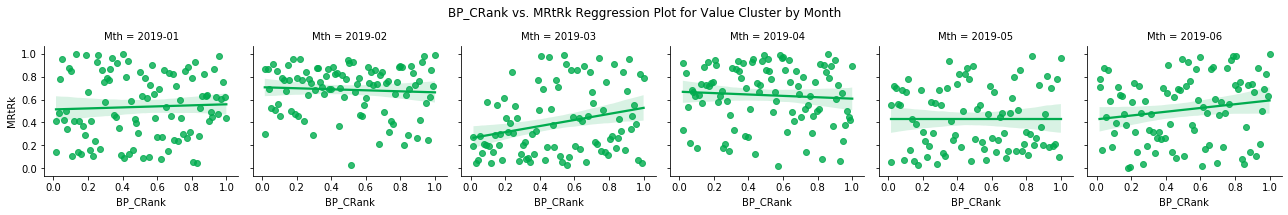

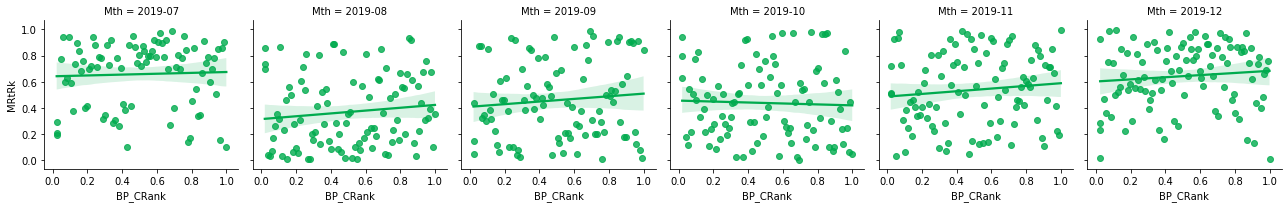

In [471]:
# valueCorner.head()
with Timer('BP_CRank vs. MRtRk Reggression Plot for Value Cluster by Month'):
    g = sns.FacetGrid(valueCorner[(valueCorner.Mth.isin(dlist[:6]))], 
                      col="Mth", # row="HML_Decile", 
                      hue = "Mth",
                      margin_titles=True)
    g.map(sns.regplot, "BP_CRank","MRtRk",color =clr2[0])
    plt.subplots_adjust(top=0.8)
    g.fig.suptitle('BP_CRank vs. MRtRk Reggression Plot for Value Cluster by Month')
    g = sns.FacetGrid(valueCorner[(valueCorner.Mth.isin(dlist[-6:]))], 
                      col="Mth", # row="HML_Decile", 
                      hue = "Mth",
                      margin_titles=True)
    g.map(sns.regplot, "BP_CRank","MRtRk",color =clr2[0])

In [467]:
# d1901[(d1901.Cluster.isin([0.0,4.0])) & (d1901.HML_Decile.isin([1,10]))]

In [470]:
fd.head()


ActRtn12M  ActRtn3M        BP  ChgShare   EBITDAP  \
Date       SecurityId                                                      
2019-07-31 MCD          0.142599  0.728559  0.969163  0.276292  0.689286   
           RGLD         0.413357  0.982317  0.548018  0.587344  0.832143   
           MGA          0.773466  0.183024  0.198238  0.038324  0.061607   
2019-12-31 COG          0.946703  0.248453  0.503993  0.108252  0.107014   
2019-06-28 69743510     0.459002  0.075850  0.860485  0.841921  0.910448   

                         FCFROI  FF10MRtn      ROIC     TTMSP       GPM  ...  \
Date       SecurityId                                                    ...   
2019-07-31 MCD         0.518190  0.109107  0.077887  0.851101  0.450000  ...   
           RGLD        0.416149  0.382326  0.771710  0.962115  0.178431  ...   
           MGA         0.257320  0.867448  0.162936  0.045815  0.971569  ...   
2019-12-31 COG         0.183199  0.903517  0.094118  0.577640  0.319361  ...   
2019-06-28 69743510    0.022707  0.224000  0.900353  0.835355  0.262248  ...   

                            MRet      QRet      HYRet  YRet  HML_Decile  \
Date       SecurityId                                                     
2019-07-31 MCD          3.991077 -6.156604   2.738848   NaN          10   
           RGLD        16.539980  1.078405   1.206771   NaN           4   
           MGA          0.133289  7.446939   1.979854   NaN           3   
2019-12-31 COG        -18.538086       NaN        NaN   NaN           8   
2019-06-28 69743510    11.179832  0.034368  13.491368   NaN           6   

                       MOM_Decile     MRtRk     QRtRk    HYRtRk  YRtRk  
Date       SecurityId                                                   
2019-07-31 MCD                  3  0.198406  0.710854  0.544395    NaN  
           RGLD                 7  0.019486  0.473310  0.587444    NaN  
           MGA                  8  0.347210  0.254448  0.565919    NaN  
2019-12-31 COG                 10  0.968944       NaN       NaN    NaN  
2019-06-28 69743510             9  0.059130  0.540210  0.326872    NaN  

[5 rows x 25 columns]

In [215]:
fd.columns

Index(['ActRtn12M', 'ActRtn3M', 'BP', 'ChgShare', 'EBITDAP', 'FCFROI',
       'FF10MRtn', 'ROIC', 'TTMSP', 'GPM', 'Cluster', 'BP_CRank',
       'ActRtn12M_CRank', 'TReturn', 'Flag', 'MRet', 'QRet', 'HYRet', 'YRet',
       'HML_Decile', 'MOM_Decile', 'MRtRk', 'QRtRk', 'HYRtRk', 'YRtRk'],
      dtype='object')

In [246]:
d1901.head()
d1901.columns

Index(['ActRtn12M', 'ActRtn3M', 'BP', 'ChgShare', 'EBITDAP', 'FCFROI',
       'FF10MRtn', 'ROIC', 'TTMSP', 'GPM', 'Cluster', 'BP_CRank',
       'ActRtn12M_CRank', 'TReturn', 'Flag', 'MRet', 'QRet', 'HYRet', 'YRet',
       'HML_Decile', 'MOM_Decile', 'MRtRk', 'QRtRk', 'HYRtRk', 'YRtRk'],
      dtype='object')